In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for Statistical Models
import statsmodels.api as sm

# Time series Models
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

# Error Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

# Misc Utils
from decimal import ROUND_HALF_UP, Decimal
from pathlib import Path
from tqdm.notebook import tqdm

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('output_new.csv')
df_test = pd.read_csv('stock_prices_test.csv')

In [4]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index("Date", inplace=True)
    return price

In [5]:
df_train = adjust_price(df_train)
df_test = adjust_price(df_test)

In [6]:
df_train = df_train.replace("－", np.nan)
df_train = df_train.fillna(method='ffill')
df_train = df_train.fillna(method='bfill')
df_train.isnull().sum().sum()

0

In [7]:
df_train = df_train.replace("－", np.nan)
df_train = df_train.fillna(method='ffill')
df_train = df_train.fillna(method='bfill')
df_train.isnull().sum().sum()

0

In [8]:
df_train = df_train.filter(["Date", "SecuritiesCode", "Open","High","Low","Volume","Close","AdjustedClose"])
df_test = df_test.filter(["Date", "SecuritiesCode", "Open","High","Low","Volume","Close","AdjustedClose"])

In [9]:
all_seccodes = df_train['SecuritiesCode'].unique()

In [10]:
def adjusted_close_sequence(df_train, df_test, seccode):
    df_Price_test = df_test.loc[df_test["SecuritiesCode"] == seccode].copy()
    test_data = df_Price_test['AdjustedClose']
    test_data_log = np.log(test_data)
    df_Price_train = df_train.loc[df_train["SecuritiesCode"] == seccode].copy()
    train_data = df_Price_train['AdjustedClose']
    train_data_log = np.log(train_data)
    return train_data_log, test_data_log

In [ ]:
def model_fit_predict(train_data):
    # model_autoARIMA = auto_arima(train_data, stepwise=True,seasonal = False)
    model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    # print(model_autoARIMA.summary())
    model_autoARIMA.plot_diagnostics(figsize=(15,8))
    # plt.show()
    return model_autoARIMA.predict(2)

In [12]:
tr_d, ts_d = adjusted_close_sequence(df_train, df_test, 9369)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5313.999, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5406.057, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5429.518, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5315.872, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5429.255, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5429.888, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5428.642, Time=0.43 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-5429.035, Time=0.96 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5426.973, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5431.507, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5431.166, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5430.266, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-5430.671, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5430.844, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0

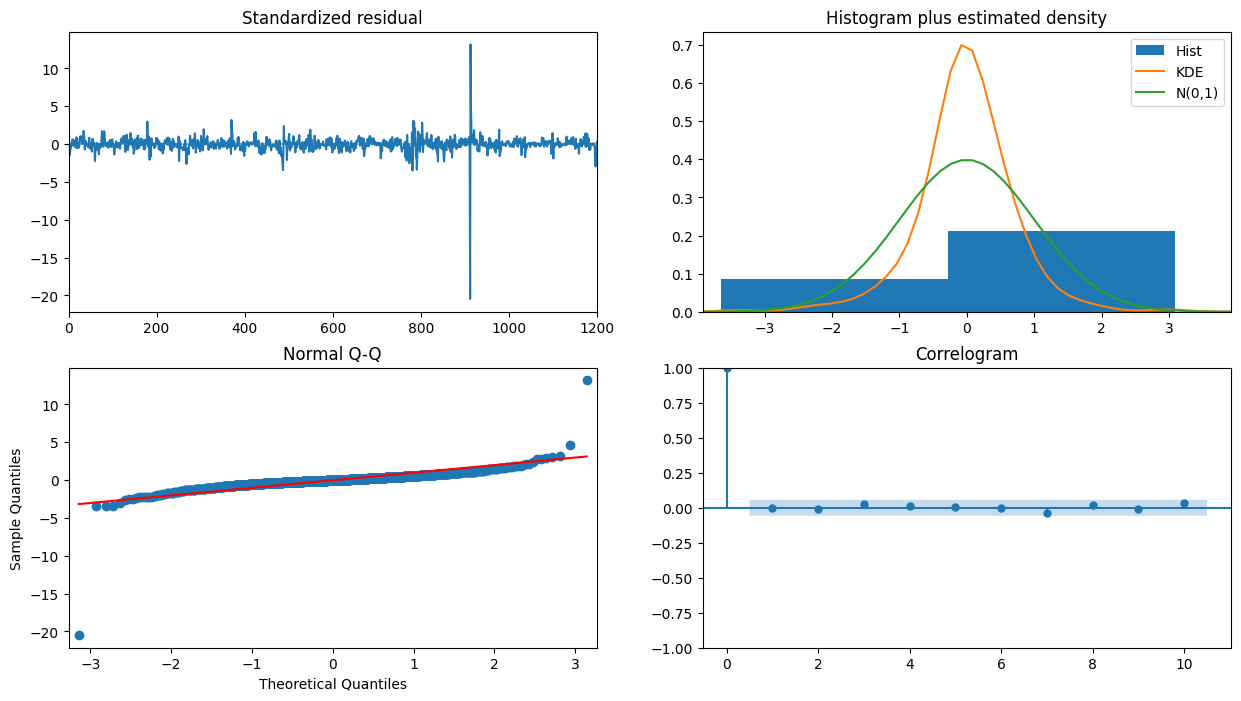

In [13]:
pred = model_fit_predict(tr_d)

In [14]:
print(ts_d)
print(pred)

Date
2021-12-06    6.777647
2021-12-07    6.799056
Name: AdjustedClose, dtype: float64
1202    6.789824
1203    6.789507
dtype: float64


In [15]:
from sklearn.metrics import mean_squared_error
import math
import random


In [ ]:
all_rmse = []
all_pred = []
all_train_seccodes = []
for i in random.sample(list(all_seccodes), 200):
    tr_d, ts_d = adjusted_close_sequence(df_train, df_test, i)
    if ts_d.isnull().any().any() or tr_d.isnull().any().any():
        continue
    pred = model_fit_predict(tr_d)
    err = math.sqrt(mean_squared_error(np.exp(ts_d), np.exp(pred)))
    print("Error: ", err)
    all_rmse.append(err)
    all_pred.append(pred)
    all_train_seccodes.append(i)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4592.500, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4651.118, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4647.971, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4594.378, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4649.146, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4649.139, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4647.114, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4652.930, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4650.956, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4650.949, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4649.770, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4648.930, Time=0.28 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.538 seconds
Error:  6.555096414830272
Performing stepwise search to minimize aic
 ARIMA(

In [ ]:
sum(all_rmse)/len(all_rmse)

In [ ]:
all_train_seccodes

In [17]:
import pickle

# output_dixt= {"pred": all_pred, "security_code": all_train_seccodes, "errors": all_rmse}
# pickle.dump(output_dixt, open("output_prediction.pkl", "wb")) 

In [18]:
object_file = pickle.load(open("output_prediction.pkl", "rb"))

In [20]:
object_file['security_code']

[9369.0,
 8291.0,
 9506.0,
 7777.0,
 8252.0,
 6941.0,
 1980.0,
 9982.0,
 6383.0,
 9505.0,
 4116.0,
 7205.0,
 6817.0,
 7242.0,
 4390.0,
 6586.0,
 2325.0,
 8218.0,
 2269.0,
 3863.0,
 3491.0,
 3657.0,
 8364.0,
 9044.0,
 6485.0,
 7550.0,
 7094.0,
 7224.0,
 7821.0,
 8892.0,
 1726.0,
 2209.0,
 1879.0,
 6996.0,
 2676.0,
 2874.0,
 7874.0,
 7184.0,
 8059.0,
 6339.0,
 9531.0,
 7229.0,
 2003.0,
 3254.0,
 9551.0,
 8527.0,
 2491.0,
 6503.0,
 6440.0,
 2749.0,
 4188.0,
 4985.0,
 6626.0,
 4042.0,
 2588.0,
 6516.0,
 2587.0,
 1882.0,
 2395.0,
 9823.0,
 1967.0,
 2208.0,
 4435.0,
 9083.0,
 9783.0,
 6432.0,
 5803.0,
 8850.0,
 4385.0,
 3994.0,
 9766.0,
 4832.0,
 6569.0,
 8111.0,
 4228.0,
 8137.0,
 2987.0,
 6674.0,
 2751.0,
 6750.0,
 6539.0,
 4092.0,
 6345.0,
 8084.0,
 7637.0,
 4436.0,
 4812.0,
 5191.0,
 2301.0,
 2830.0,
 8051.0,
 5943.0,
 8168.0,
 9889.0,
 2805.0,
 4365.0,
 6923.0,
 8233.0,
 2503.0,
 6047.0,
 4574.0,
 3086.0,
 8869.0,
 6103.0,
 5290.0,
 6804.0,
 3405.0,
 9057.0,
 4344.0,
 4714.0,
 9919.0,
 

In [114]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

tr_d, ts_d = adjusted_close_sequence(df_train, df_test,3922)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3441.770, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3549.573, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3565.713, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3442.717, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3564.129, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3564.094, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3562.124, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3565.103, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.951 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1202
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1785.856
Date:                Sun, 05 May 2024   AIC                          -3565.713
Time:                       

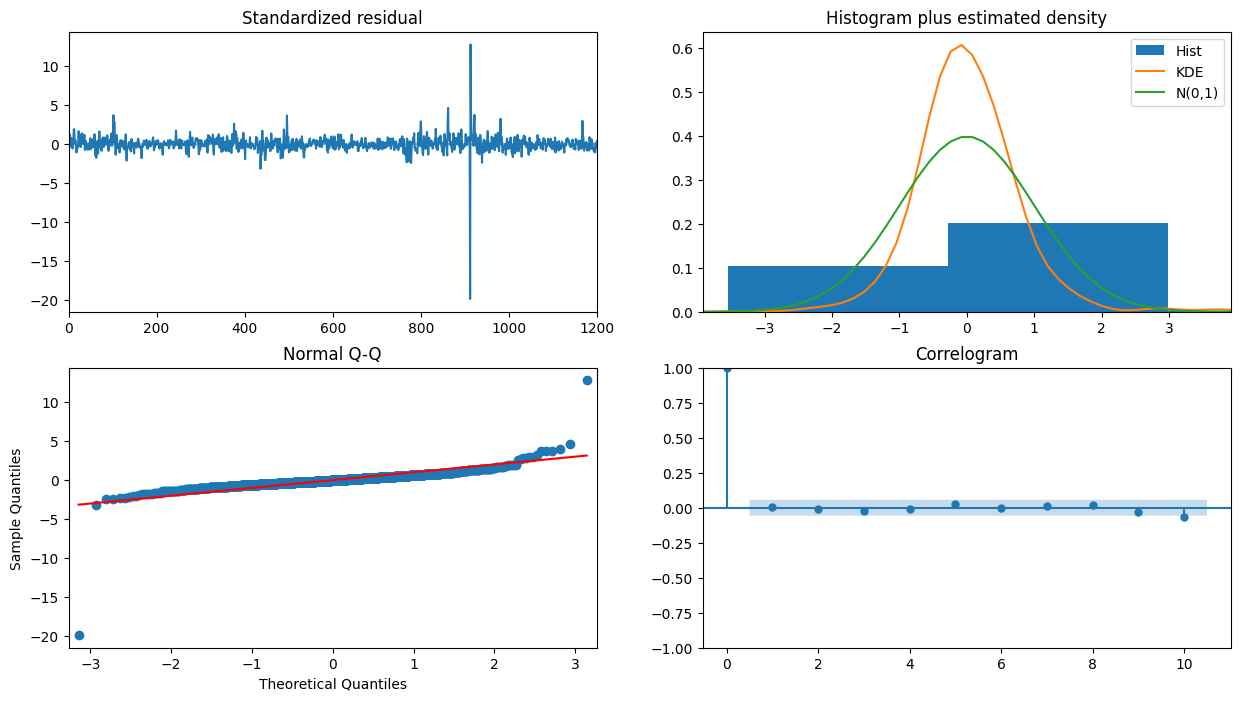

In [115]:
pred = model_fit_predict(tr_d)

<Axes: xlabel='Date'>

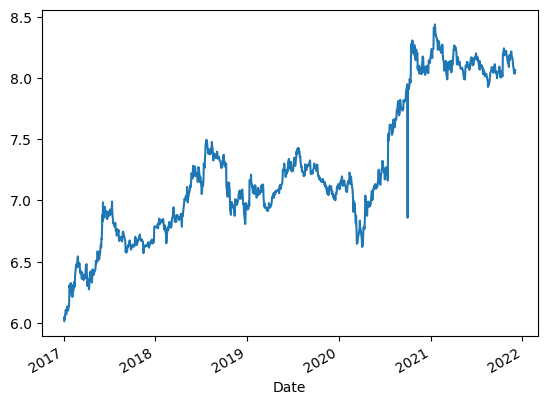

In [116]:
tr_d.plot()

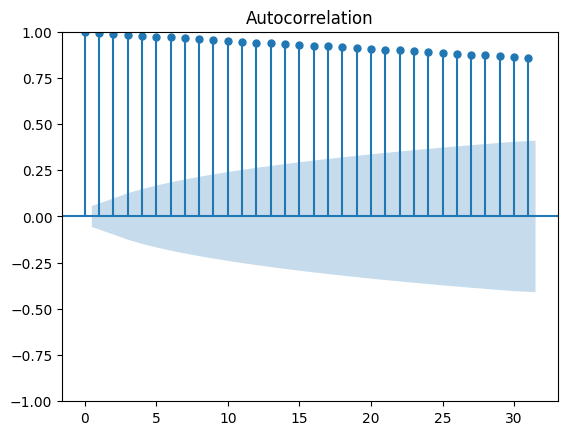

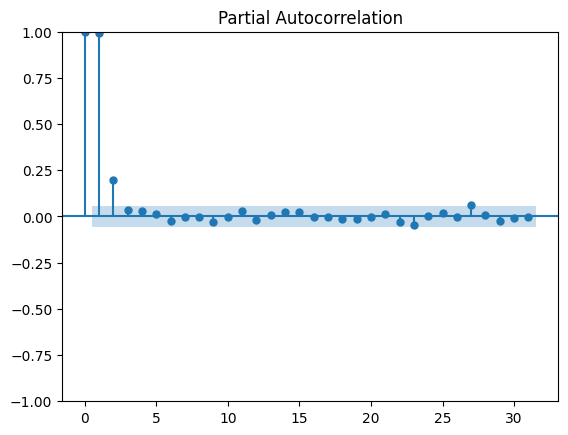

In [117]:
acf_original = plot_acf(tr_d)

pacf_original = plot_pacf(tr_d)

In [118]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(tr_d)
print(f'p-value: {adf_test[1]}')

p-value: 0.4614435125783139


<Axes: xlabel='Date'>

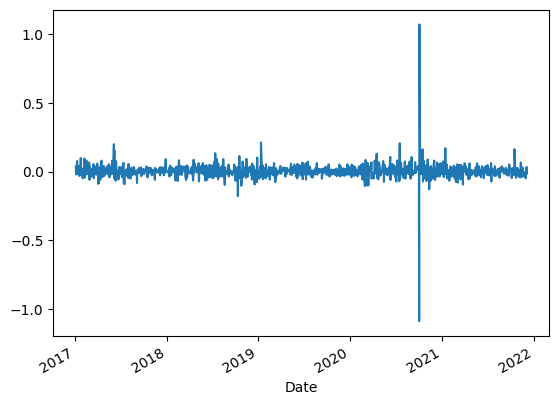

In [119]:
tr_d_diff = tr_d.diff().dropna()
tr_d_diff.plot()

In [120]:
adf_test = adfuller(tr_d_diff)
print(f'p-value: {adf_test[1]}')

p-value: 0.0


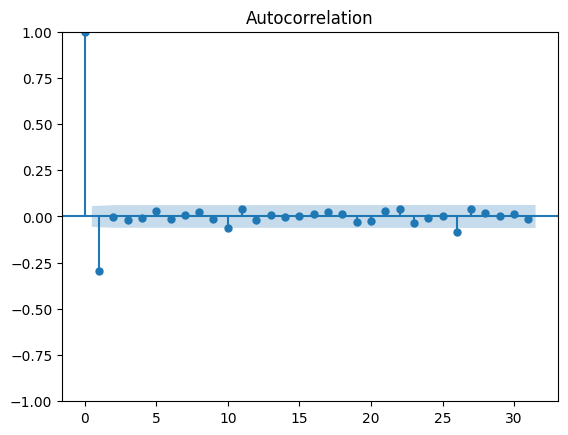

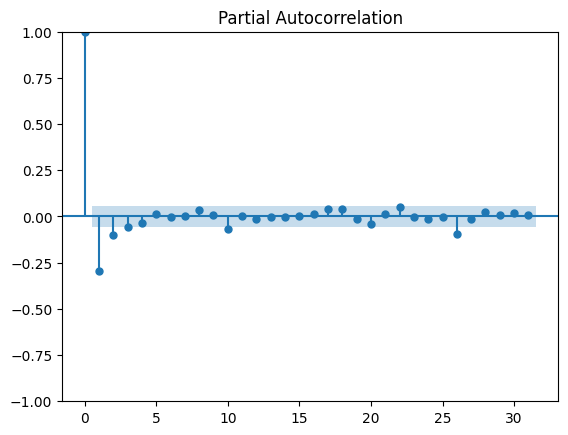

In [121]:
acf_diff = plot_acf(tr_d_diff)

pacf_diff = plot_pacf(tr_d_diff)

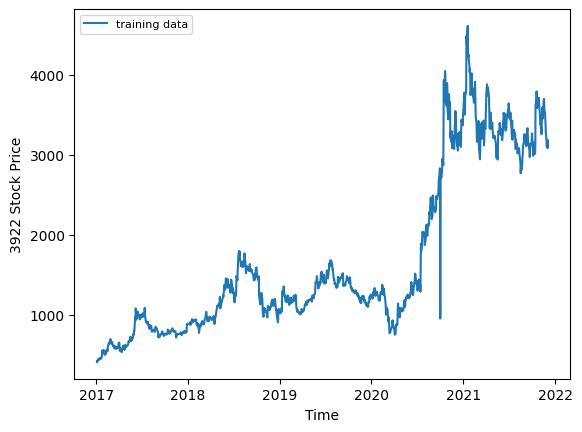

In [126]:
plt.plot(np.exp(tr_d), label='training data')
# plt.plot(ts_d, color = 'blue', label='Actual Stock Price')
# plt.plot(["2021-12-06", "2021-12-07"], pred, color = 'orange',label='Predicted Stock Price')

plt.xlabel('Time')
plt.ylabel('3922 Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [123]:
np.exp(ts_d)

Date
2021-12-06    3185.0
2021-12-07    3295.0
Name: AdjustedClose, dtype: float64

In [124]:
np.exp(pred)

1202    3163.730778
1203    3169.071014
dtype: float64

In [125]:
np.exp(tr_d[len(tr_d)-20:])

Date
2021-11-05    3400.0
2021-11-08    3260.0
2021-11-09    3480.0
2021-11-10    3535.0
2021-11-11    3595.0
2021-11-12    3450.0
2021-11-15    3555.0
2021-11-16    3665.0
2021-11-17    3700.0
2021-11-18    3700.0
2021-11-19    3575.0
2021-11-22    3505.0
2021-11-24    3370.0
2021-11-25    3270.0
2021-11-26    3255.0
2021-11-29    3100.0
2021-11-30    3185.0
2021-12-01    3145.0
2021-12-02    3085.0
2021-12-03    3180.0
Name: AdjustedClose, dtype: float64